# Building an ensemble model

## Outline
- **Gather already trained models**   
- **Stack trained models together to train an ensemble model.**
- **Save the best performing ensemble model**
- **Observe and compare all results**

Set Parent directory to the system for importing modules

In [3]:
import os
import sys
import inspect
import pathlib

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
ROOTDIR = os.path.dirname(currentdir)
print('ROOTDIR', ROOTDIR)
sys.path.insert(0,ROOTDIR)

import json
import numpy  as np
import os 
import pandas as pd

from scripts.model import get_feature_list_from_text_excluding_target
from scripts.model import get_model, get_prediction, save_model, load_saved_model
from scripts.evaluate import get_evaluation_report
from scripts.evaluate import precision_recall_curve_comparison
from scripts.evaluate import roc_curve_comparison
from scripts.utils import set_seed

seed = 112358

set_seed(seed)
results = {}

ROOTDIR E:\Data Science Masters\university\coding challenge\future_demand


### Gather Data

In [4]:
full_data = pd.read_csv(fr"{ROOTDIR}/data/prepared_data_for_modeling.csv")

target = 'next_hour_good_performance'
sample_features = get_feature_list_from_text_excluding_target(fr"{ROOTDIR}/data/feature_lists_for_modeling.txt",
                                                              target) 
                                                          
training_data = full_data[full_data['first_24_hour']][sample_features+[target]]                                              
X_train = np.ascontiguousarray(training_data[sample_features])
y_train = np.ascontiguousarray(training_data[target])

test_data = full_data[full_data['test_set']][sample_features+[target]]
X_test = np.ascontiguousarray(test_data[sample_features])
y_test = np.ascontiguousarray(test_data[target])

del training_data, test_data

Successfully returned list from:  E:\Data Science Masters\university\coding challenge\future_demand/data/feature_lists_for_modeling.txt


#### Load Trained Models

In [5]:
xgb_model = load_saved_model(fr"{ROOTDIR}/model", 'xgb_model')
lgb_model = load_saved_model(fr"{ROOTDIR}/model", 'lightGBM_model')
rf_model = load_saved_model(fr"{ROOTDIR}/model", 'rf_model')

xgb_model found at E:\Data Science Masters\university\coding challenge\future_demand/model\xgb_model.
lightGBM_model found at E:\Data Science Masters\university\coding challenge\future_demand/model\lightGBM_model.
rf_model found at E:\Data Science Masters\university\coding challenge\future_demand/model\rf_model.


In [6]:
model_results = pd.read_csv(fr"{ROOTDIR}/results/model_results.csv")
model_results.sort_values('pr_auc', ascending = False)

,Unnamed: 0,pr_auc,macro_precision,macro_recall,macro_f1,mcc
0,xgb,0.261456,0.645513,0.693417,0.665093,0.335527
1,lightgbm,0.255616,0.634736,0.690786,0.656419,0.320660
2,randomforest,0.230132,0.603067,0.710009,0.630406,0.294245


We can see xgb is the best performing with AUC of 0.26

### Ensemble Modeling or voting Classifier
Stack already trained models together to train an ensemble model.

**XGB and LGB**

[00:39:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PR-curve threshold=0.861960, F-Score=0.369


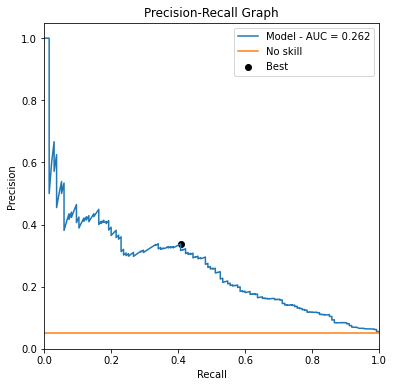

Threshold=0.860, Best macro F1-Score=0.66543

               precision    recall  f1-score   support

     Bad Ads       0.97      0.96      0.96      2470
    Good Ads       0.34      0.41      0.37       135

    accuracy                           0.93      2605
   macro avg       0.65      0.68      0.67      2605
weighted avg       0.93      0.93      0.93      2605

Matthews correlation coefficient:  0.3328674926648886


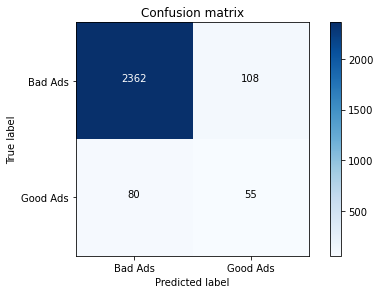

In [12]:
ensemble_classifier = get_model(name='ensemble',
                                estimators=[('lgb_model', lgb_model),('xgb_model',xgb_model)], 
                                voting='soft', 
                                weights=[1,1])
ensemble_classifier.fit(X_train, y_train)

preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, preidiction, labels, plot='precision-recall')

results['ensemble_xgb_+_lgb'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

**Observation:** Performance increased slightly with compared to xgb but very less 0.001. Let's give more weight to xgb model and see if performance increases

[00:39:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PR-curve threshold=0.853811, F-Score=0.372


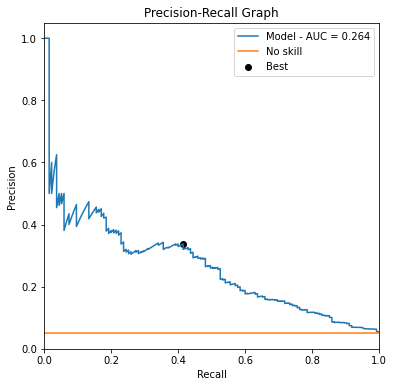

Threshold=0.854, Best macro F1-Score=0.66680

               precision    recall  f1-score   support

     Bad Ads       0.97      0.96      0.96      2470
    Good Ads       0.34      0.41      0.37       135

    accuracy                           0.93      2605
   macro avg       0.65      0.69      0.67      2605
weighted avg       0.93      0.93      0.93      2605

Matthews correlation coefficient:  0.3360362604772327


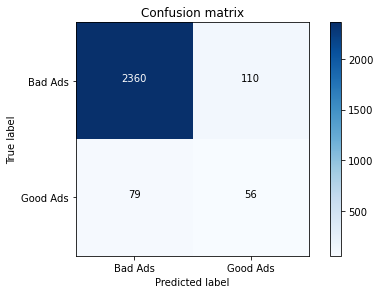

In [13]:
ensemble_classifier = get_model(name='ensemble',
                                estimators=[('lgb_model', lgb_model),('xgb_model',xgb_model)], 
                                voting='soft', weights=[1,2])
ensemble_classifier.fit(X_train, y_train)

preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, preidiction, labels, plot='precision-recall')
results['ensemble_weighted_xgb_+_lgb'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

We can observe a better improvement an increase of 0.003 of PR-AUC w.r.t XgBoost

**XGB and Random Forest**

[00:40:06] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PR-curve threshold=0.788638, F-Score=0.362


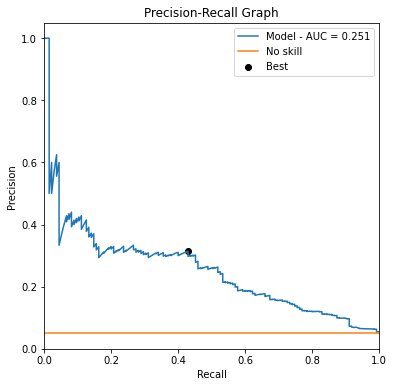

Threshold=0.789, Best macro F1-Score=0.66039

               precision    recall  f1-score   support

     Bad Ads       0.97      0.95      0.96      2470
    Good Ads       0.31      0.43      0.36       135

    accuracy                           0.92      2605
   macro avg       0.64      0.69      0.66      2605
weighted avg       0.93      0.92      0.93      2605

Matthews correlation coefficient:  0.32640577662537656


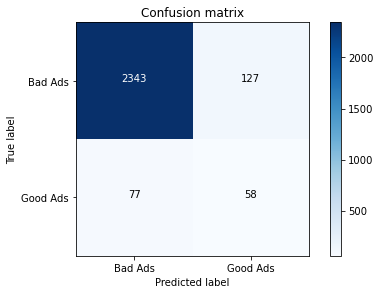

In [14]:
ensemble_classifier = get_model(name='ensemble',estimators=[('xgb', xgb_model),('rf',rf_model)], 
                                voting='soft', 
                                weights=[1,1])
ensemble_classifier.fit(X_train, y_train)

preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, preidiction, labels, plot='precision-recall')
results['ensemble_xgb_+_rf'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

 Giving double weight to XGB model

[00:40:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PR-curve threshold=0.803220, F-Score=0.379


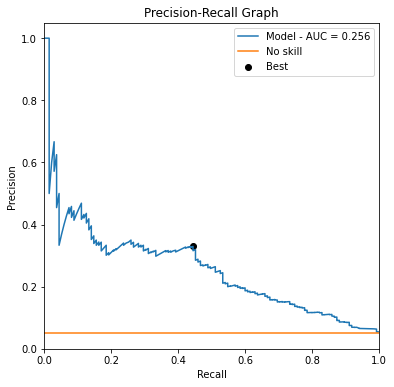

Threshold=0.803, Best macro F1-Score=0.66914

               precision    recall  f1-score   support

     Bad Ads       0.97      0.95      0.96      2470
    Good Ads       0.33      0.44      0.38       135

    accuracy                           0.92      2605
   macro avg       0.65      0.70      0.67      2605
weighted avg       0.94      0.92      0.93      2605

Matthews correlation coefficient:  0.34352387805305884


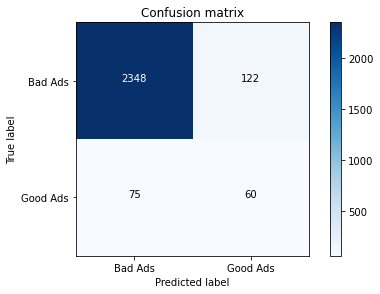

In [15]:
ensemble_classifier = get_model(name='ensemble',
                                estimators=[('xgb', xgb_model),('rf',rf_model)], 
                                voting='soft', weights=[2,1])

ensemble_classifier.fit(X_train, y_train)

preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, preidiction, labels, plot='precision-recall')

results['ensemble_weighted_xgb_+_rf'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

Observation: Nothing Interesting so far

**LGB and RF**

PR-curve threshold=0.799571, F-Score=0.352


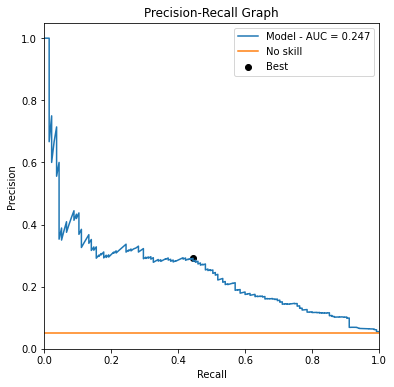

Threshold=0.799, Best macro F1-Score=0.65326

               precision    recall  f1-score   support

     Bad Ads       0.97      0.94      0.95      2470
    Good Ads       0.29      0.44      0.35       135

    accuracy                           0.92      2605
   macro avg       0.63      0.69      0.65      2605
weighted avg       0.93      0.92      0.92      2605

Matthews correlation coefficient:  0.31652297140046054


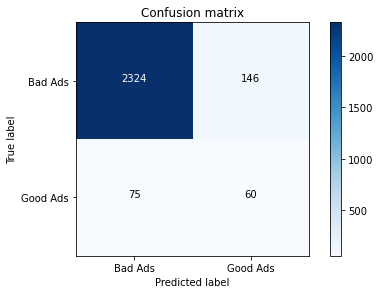

In [16]:
ensemble_classifier = get_model(name='ensemble',
                                estimators=[('lgb',lgb_model),('rf_model',rf_model)], 
                                voting='soft', 
                                weights=[1,1])

ensemble_classifier.fit(X_train, y_train)

preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, preidiction, labels, plot='precision-recall')


results['ensemble_lgb_rf'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

**Ensemble of all 3 classifiers**

[00:41:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PR-curve threshold=0.817394, F-Score=0.367


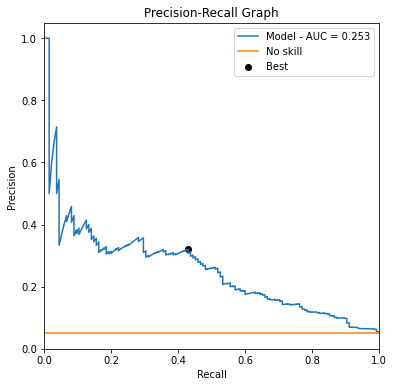

Threshold=0.817, Best macro F1-Score=0.66311

               precision    recall  f1-score   support

     Bad Ads       0.97      0.95      0.96      2470
    Good Ads       0.32      0.43      0.37       135

    accuracy                           0.92      2605
   macro avg       0.64      0.69      0.66      2605
weighted avg       0.93      0.92      0.93      2605

Matthews correlation coefficient:  0.33113217610667706


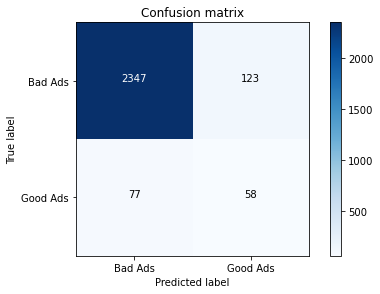

In [17]:
ensemble_classifier = get_model(name='ensemble',
                                estimators=[('xgb',xgb_model),
                                            ('lgb',lgb_model),('rf',rf_model)], 
                                            voting='soft', 
                                            weights=[1,1,1])
ensemble_classifier.fit(X_train, y_train)
preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, preidiction, labels, plot='precision-recall')
results['ensemble_all'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

Giving more weight to XGB model

[00:41:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PR-curve threshold=0.819581, F-Score=0.369


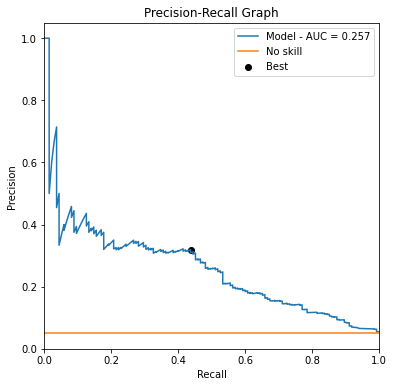

Threshold=0.819, Best macro F1-Score=0.66304

               precision    recall  f1-score   support

     Bad Ads       0.97      0.95      0.96      2470
    Good Ads       0.32      0.44      0.37       135

    accuracy                           0.92      2605
   macro avg       0.64      0.69      0.66      2605
weighted avg       0.93      0.92      0.93      2605

Matthews correlation coefficient:  0.33197130220086585


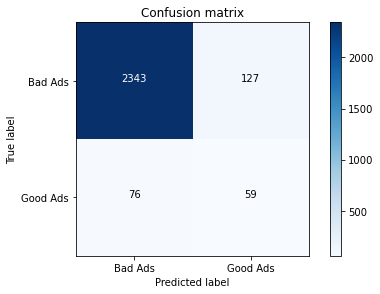

In [18]:
ensemble_classifier = get_model(name='ensemble',
                                estimators=[('xgb',xgb_model),('lgb',lgb_model),('rf_model',rf_model)], 
                                voting='soft', 
                                weights=[2,1,1])
ensemble_classifier.fit(X_train, y_train)
preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, preidiction, labels, plot='precision-recall')

results['ensemble_all_xgb_weighted'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

Observation: We can observe ensemble model of weighted xgb and lightgbm is the best performing amongst all

#### Gather Result

In [23]:
ensemble_results = pd.DataFrame.from_dict(results).T
ensemble_results.columns = ['pr_auc', 'macro_precision', 'macro_recall', 'macro_f1', 'mcc']
ensemble_results.to_csv(fr"{ROOTDIR}/results/ensemble_model_results.csv")
ensemble_results.sort_values('pr_auc', ascending=False)

,Unnamed: 0,pr_auc,macro_precision,macro_recall,macro_f1,mcc
0,ensemble_xgb_+_lgb,0.261863,0.652332,0.681841,0.665427,0.332867
1,ensemble_weighted_xgb_+_lgb,0.263704,0.652480,0.685140,0.666796,0.336036
2,ensemble_xgb_+_rf,0.250699,0.640848,0.689106,0.660391,0.326406
3,ensemble_weighted_xgb_+_rf,0.255918,0.649358,0.697526,0.669144,0.343524
4,ensemble_lgb_rf,0.246819,0.630000,0.692668,0.653258,0.316523
5,ensemble_all,0.253141,0.644338,0.689916,0.663111,0.331132
6,ensemble_all_xgb_weighted,0.256589,0.642893,0.692810,0.663040,0.331971


In [ ]:
ensemble_classifier = get_model(name='ensemble',
                                estimators=[('lgb_model', lgb_model),('xgb_model',xgb_model)], 
                                voting='soft', weights=[1,2])

ensemble_classifier.fit(X_train, y_train)

preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, 
                               preidiction, 
                               labels, 
                               plot='precision-recall',
                               save_path = fr"{}
                              )


#### Save the best ensemble model

[02:31:07] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PR-curve threshold=0.853811, F-Score=0.372


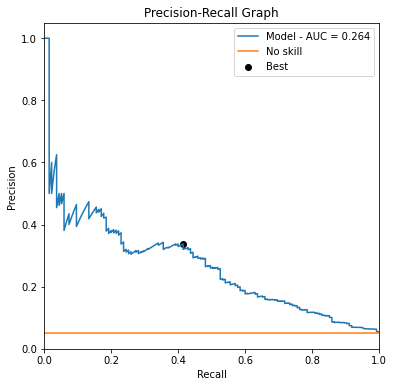

Threshold=0.854, Best macro F1-Score=0.66680

               precision    recall  f1-score   support

     Bad Ads       0.97      0.96      0.96      2470
    Good Ads       0.34      0.41      0.37       135

    accuracy                           0.93      2605
   macro avg       0.65      0.69      0.67      2605
weighted avg       0.93      0.93      0.93      2605

Matthews correlation coefficient:  0.3360362604772327


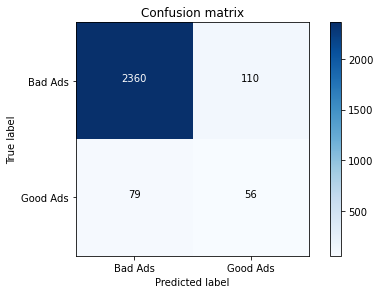

ensemble_model.pickle.dat saved in : E:\Data Science Masters\university\coding challenge\future_demand/model


In [7]:
save_path = fr"{ROOTDIR}\\plots\\EnsembleModel\\"

ensemble_classifier = get_model(name='ensemble',
                                estimators=[('lgb_model', lgb_model),('xgb_model',xgb_model)], 
                                voting='soft', weights=[1,2])

ensemble_classifier.fit(X_train, y_train)

preidiction = get_prediction(ensemble_classifier, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, 
                               preidiction, 
                               labels, 
                               plot='precision-recall',
                               save_path = save_path = save_path+'test'
                              )

path = fr"{ROOTDIR}/model"
model_name = 'ensemble_model'
save_model(ensemble_classifier, path, model_name)

On Training set

ensemble_model found at E:\Data Science Masters\university\coding challenge\future_demand/model\ensemble_model.
PR-curve threshold=0.832431, F-Score=0.386


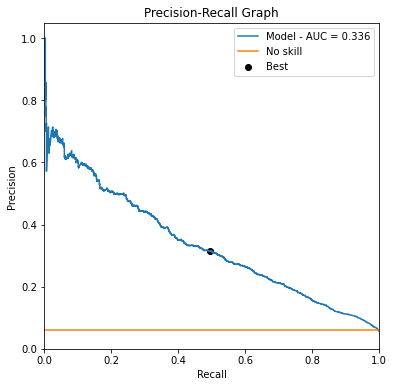


               precision    recall  f1-score   support

     Bad Ads       0.97      0.95      0.96     19701
    Good Ads       0.33      0.43      0.38      1179

    accuracy                           0.92     20880
   macro avg       0.65      0.69      0.67     20880
weighted avg       0.93      0.92      0.92     20880

Matthews correlation coefficient:  0.33685404289363


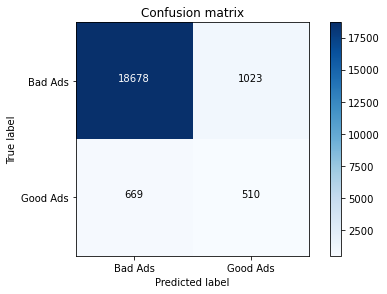

In [21]:
##used to load saved model
#ensemble_trained = load_saved_model(fr"{ROOTDIR}/model", 'ensemble_model')

preidiction = get_prediction(ensemble_trained, X_train)
labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_train, 
                               preidiction, 
                               labels, 
                               plot='precision-recall',
                               save_path = save_path+'train',
                               threshold = report['threshold'],
                              )

### Observe and compare results

In [88]:
results_df = pd.DataFrame.from_dict(results).T
results_df.columns = ['pr_auc', 'macro_precision', 'macro_recall', 'macro_f1', 'mcc']
#results_df.to_csv(fr"{ROOTDIR}/model/results.csv")
results_df

,pr_auc,macro_precision,macro_recall,macro_f1,mcc
xgb,0.261456,0.645513,0.693417,0.665093,0.335527
lightgbm,0.255616,0.634736,0.690786,0.656419,0.320660
randomforest,0.230132,0.603067,0.710009,0.630406,0.294245
ensemble_xgb_lgb,0.263704,0.652480,0.685140,0.666796,0.336036
ensemble_xgb_rf,0.255918,0.649358,0.697526,0.669144,0.343524
ensemble_lgb_rf,0.246819,0.630000,0.692668,0.653258,0.316523
ensemble_all,0.256589,0.642893,0.692810,0.663040,0.331971


In [22]:
combined_results = model_results.append(ensemble_results)
combined_results.sort_values('pr_auc', ascending=False)

,Unnamed: 0,pr_auc,macro_precision,macro_recall,macro_f1,mcc
1,ensemble_weighted_xgb_+_lgb,0.263704,0.652480,0.685140,0.666796,0.336036
0,ensemble_xgb_+_lgb,0.261863,0.652332,0.681841,0.665427,0.332867
0,xgb,0.261456,0.645513,0.693417,0.665093,0.335527
6,ensemble_all_xgb_weighted,0.256589,0.642893,0.692810,0.663040,0.331971
3,ensemble_weighted_xgb_+_rf,0.255918,0.649358,0.697526,0.669144,0.343524
1,lightgbm,0.255616,0.634736,0.690786,0.656419,0.320660
5,ensemble_all,0.253141,0.644338,0.689916,0.663111,0.331132
2,ensemble_xgb_+_rf,0.250699,0.640848,0.689106,0.660391,0.326406
4,ensemble_lgb_rf,0.246819,0.630000,0.692668,0.653258,0.316523
2,randomforest,0.230132,0.603067,0.710009,0.630406,0.294245


#### Let's check everything in a PR-AUC curve (only taking best ensemble model)

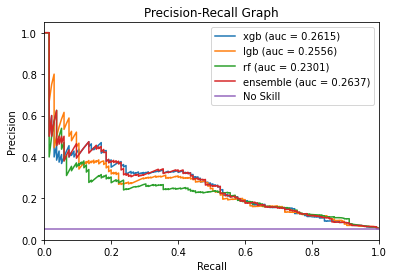

In [9]:
temp_model_dict = {'xgb':xgb_model, 'lgb':lgb_model, 'rf':rf_model, 'ensemble':ensemble_model}
precision_recall_curve_comparison(temp_model_dict, X_test, y_test, save_path = fr"{ROOTDIR}/plots")

Let's check out everything on Roc Curve

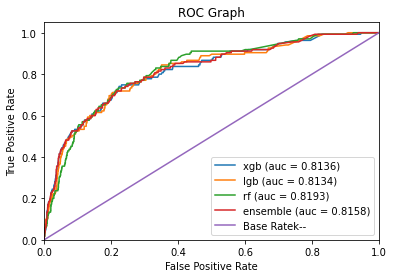

In [10]:
temp_model_dict = {'xgb':xgb_model, 'lgb':lgb_model, 'rf':rf_model, 'ensemble':ensemble_model}
roc_curve_comparison(temp_model_dict, X_test, y_test, save_path = fr"{ROOTDIR}/plots")

Observation: We can see here how roc-auc tricks us when data is highly imbalanced